# Pruebas normalización

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [3]:
RANGE_VISUALIZ = [35.0, 38.0] # Rango de temperaturas para la visualización

fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h') # Para alinear las gráficas

In [4]:
with open("../procData/muestras_ovul_imput.pkl", "rb") as f:
    muestras_ovul = pickle.load(f)

### Calcular medias horarias para cada serie

In [5]:
muestras_ovul_horas = {}

for key, data in muestras_ovul.items():
    df = data["serie"].copy()

    # Redondear timestamps a la hora
    df["resultTimestamp"] = df["resultTimestamp"].dt.floor("h")

    # Calcular media horaria
    df_horas = df.groupby("resultTimestamp", as_index=False)["result"].mean()

    muestras_ovul_horas[key] = {
        "serie": df_horas,
        "ovul": data["ovul"]
    }

In [6]:
with open("../procData/muestras_ovul_horas.pkl", "wb") as f:
    pickle.dump(muestras_ovul_horas, f)

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Tiene dos modos de mostrar cada serie original y corregida: solapadas o separadas

def print_series_zoom(muestras_orig, muestras_corr, list_ids, modo_visualizacion='solapadas'):

    fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h')

    for id in list_ids:
        serie_orig = muestras_orig[id]["serie"]
        serie_corr = muestras_corr[id]["serie"]

        x_orig = (serie_orig["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y_orig = serie_orig["result"]
        x_corr = (serie_corr["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y_corr = serie_corr["result"]

        if modo_visualizacion == 'solapadas':
            fig = go.Figure()

            fig.add_trace(go.Scatter(
                x=x_orig,
                y=y_orig,
                mode='markers',
                name=f'{id} (cada 2 min.)',
                marker=dict(size=4, color='#2980B9'),
            ))

            fig.add_trace(go.Scatter(
                x=x_corr,
                y=y_corr,
                mode='markers',
                name=f'{id} (cada hora)',
                marker=dict(size=4, color='#1E8449' )
            ))

            fig.add_shape(
                type="line", x0=0, x1=0, y0=35.0, y1=37.7,
                line=dict(color="red", width=2, dash="dash")
            )
            fig.add_annotation(
                x=0, y=37.7, text="Ovulación", showarrow=False,
                yanchor="bottom", font=dict(color="red")
            )

            fig.update_layout(
                title=f"Serie {id}: Medidas cada 2min. y cada hora",
                xaxis_title="Día relativo a la ovulación",
                yaxis_title="Temperatura (°C)",
                hovermode="x unified",
                template="plotly_white",
                height=400
            )
            fig.update_yaxes(range=RANGE_VISUALIZ)

        elif modo_visualizacion == 'separadas':
            fig = make_subplots(rows=2, cols=1,
                                shared_xaxes=True,
                                subplot_titles=[f"{id} (Cada 2 min.)", f"{id} (Cada hora)"],
                                vertical_spacing=0.1)

            fig.add_trace(go.Scatter(
                x=x_orig,
                y=y_orig,
                mode='markers',
                name='Original',
                marker=dict(size=4, color='#2980B9'),
            ), row=1, col=1)

            fig.add_trace(go.Scatter(
                x=x_corr,
                y=y_corr,
                mode='markers',
                name='Corregida',
                marker=dict(size=4, color='#1E8449')
            ), row=2, col=1)

            # Línea de ovulación en ambas subgráficas
            for row in [1, 2]:
                fig.add_shape(
                    type="line", x0=0, x1=0, y0=35.0, y1=37.7,
                    line=dict(color="red", width=2, dash="dash"),
                    row=row, col=1
                )
                fig.add_annotation(
                    x=0, y=37.7, text="Ovulación", showarrow=False,
                    yanchor="bottom", font=dict(color="red"),
                    row=row, col=1
                )

            fig.update_layout(
                title_text=f"Serie {id}: Original y Corregida",
                height=600,
                template="plotly_white",
                hovermode="x unified"
            )
            fig.update_yaxes(range=RANGE_VISUALIZ, row=1, col=1)
            fig.update_yaxes(range=RANGE_VISUALIZ, row=2, col=1)
            fig.update_xaxes(title_text="Día relativo a la ovulación", row=2, col=1)
            fig.update_yaxes(title_text="Temperatura (°C)", row=1, col=1)
            fig.update_yaxes(title_text="Temperatura (°C)", row=2, col=1)

        else:
            raise ValueError("El parámetro 'modo_visualizacion' debe ser 'solapadas' o 'separadas'.")
        
        fig.show()


In [8]:
print_series_zoom(muestras_orig=muestras_ovul, muestras_corr=muestras_ovul_horas, list_ids = list(muestras_ovul.keys())[:5], modo_visualizacion="separadas")

### Media y desviación típica de las series originales

In [9]:
todas_series = []

for key, datos in muestras_ovul_horas.items():
    df = datos["serie"].copy()
    todas_series.append(df[["resultTimestamp", "result"]])

# Concatenar y agrupar por hora
df_todas = pd.concat(todas_series)
resumen_orig = df_todas.groupby("resultTimestamp").agg(["mean", "std"]).reset_index()
resumen_orig.columns = ["resultTimestamp", "mean", "std"]

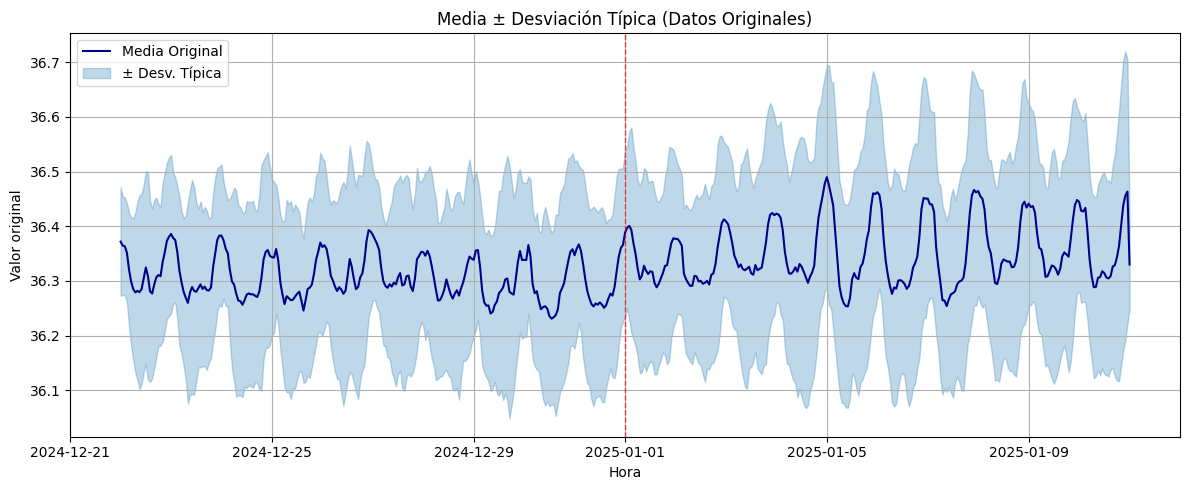

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(resumen_orig["resultTimestamp"], resumen_orig["mean"], label="Media Original", color="darkblue")
plt.fill_between(
    resumen_orig["resultTimestamp"],
    resumen_orig["mean"] - resumen_orig["std"],
    resumen_orig["mean"] + resumen_orig["std"],
    color="#2980B9", alpha=0.3, label="± Desv. Típica"
)
plt.axvline(x=fecha_ref, color="red", linestyle="--", linewidth=1, alpha=0.7)
plt.title("Media ± Desviación Típica (Datos Originales)")
plt.xlabel("Hora")
plt.ylabel("Valor original")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Crear listas para guardar medias y desviaciones por serie
medias_por_serie = []
stds_por_serie = []

for key, datos in muestras_ovul_horas.items():
    df = datos["serie"]
    medias_por_serie.append(df["result"].mean())
    stds_por_serie.append(df["result"].std())


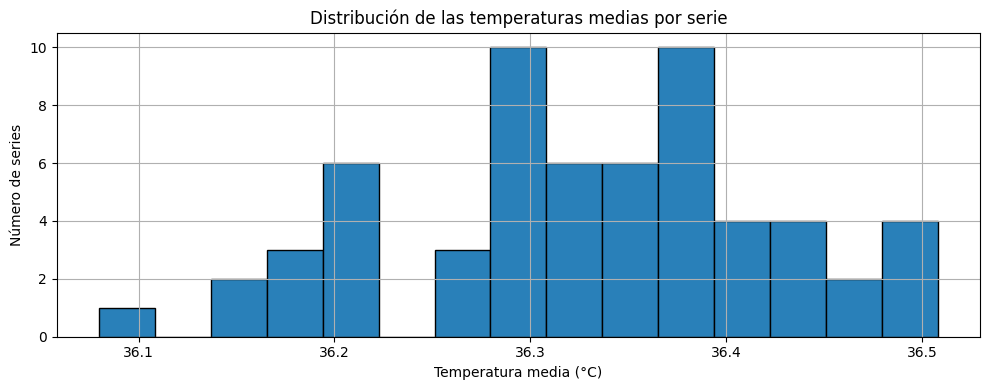

In [12]:
plt.figure(figsize=(10, 4))
plt.hist(medias_por_serie, bins=15, color="#2980B9", edgecolor="black")
plt.title("Distribución de las temperaturas medias por serie")
plt.xlabel("Temperatura media (°C)")
plt.ylabel("Número de series")
plt.grid(True)
plt.tight_layout()
plt.show()

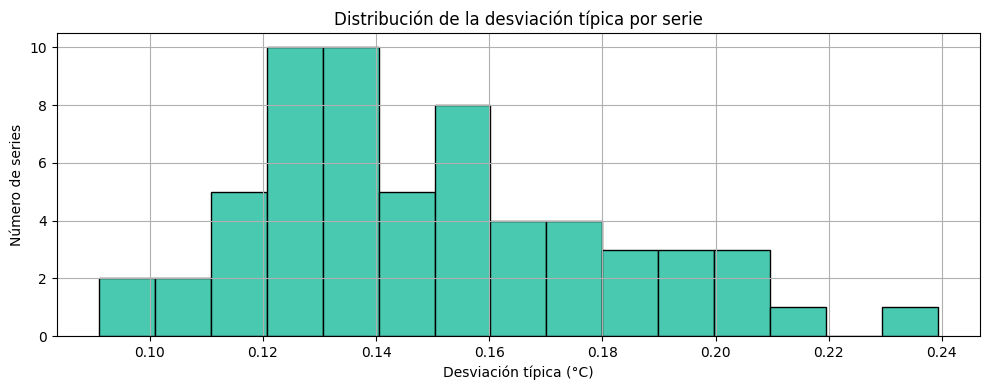

In [13]:
plt.figure(figsize=(10, 4))
plt.hist(stds_por_serie, bins=15, color="#48C9B0", edgecolor="black")
plt.title("Distribución de la desviación típica por serie")
plt.xlabel("Desviación típica (°C)")
plt.ylabel("Número de series")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Calcular la desviación típica de cada serie
stds_por_serie = {
    key: datos["serie"]["result"].std()
    for key, datos in muestras_ovul_horas.items()
}

# Calcular umbral (media + 1.5*std)
std_values = np.array(list(stds_por_serie.values()))
umbral = np.mean(std_values) + 1.55*np.std(std_values)
# umbral = np.percentile(std_values, 90)  # Si queremos tomar el percentil 90

# Series consideradas "ruidosas"
series_raras_std = [k for k, v in stds_por_serie.items() if v > umbral]

series_raras_std

['TU017_2', 'TU074_2', 'TU074_3', 'AN007_1', 'AN007_3']

In [21]:
stds_ordenadas = sorted(stds_por_serie.items(), key=lambda x: x[1])

# Ejemplo de serie con std baja (mínima)
baja = stds_ordenadas[0][0]

# Ejemplo con std media (aproximadamente el valor central)
media = stds_ordenadas[len(stds_ordenadas) // 2][0]

# Ejemplo con std alta (máxima)
alta = stds_ordenadas[-1][0]

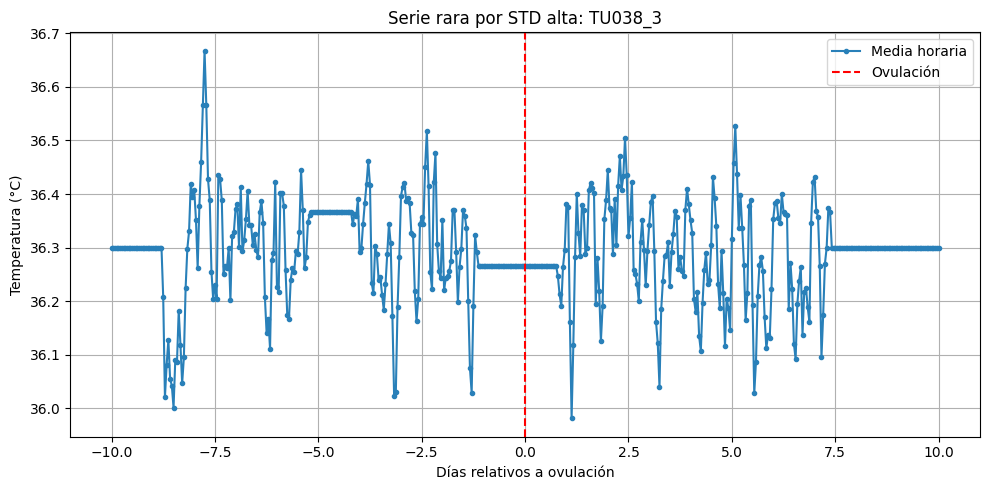

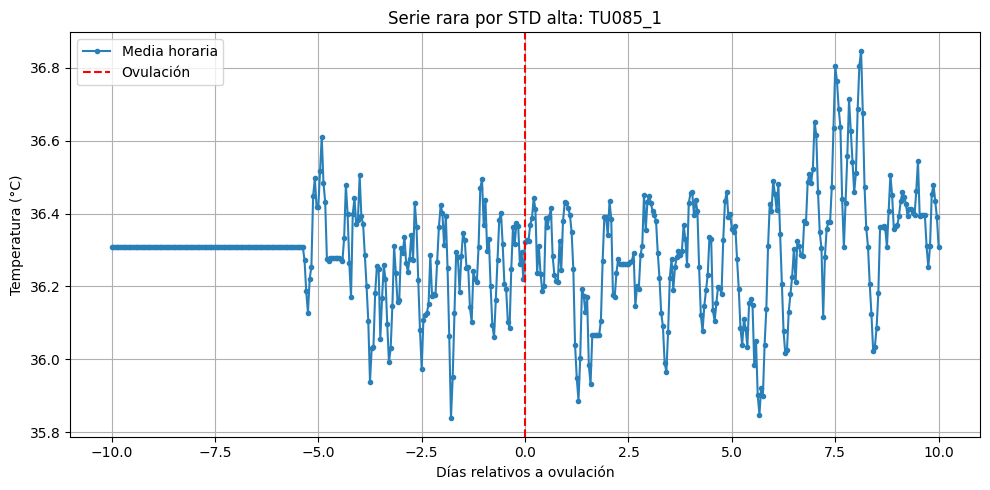

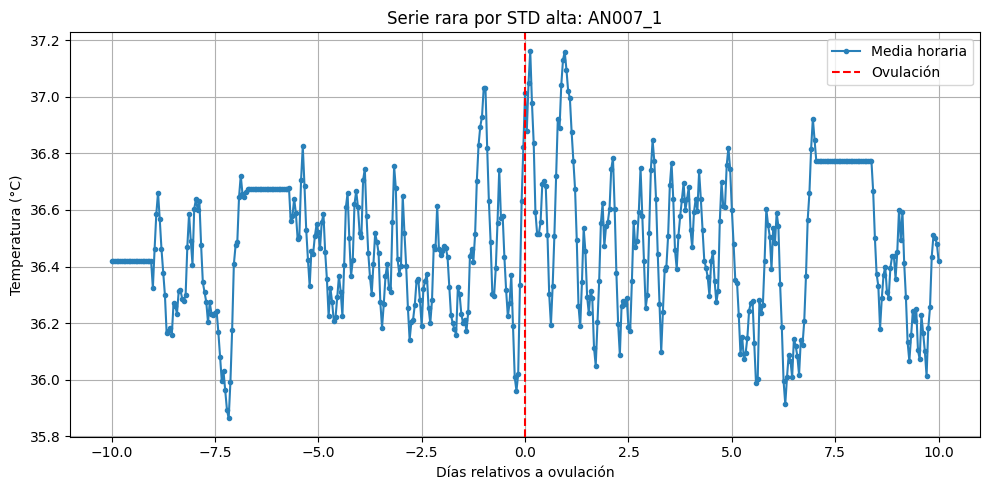

In [23]:
for key in [baja, media, alta]:
    df = muestras_ovul_horas[key]["serie"].copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)

    plt.figure(figsize=(10, 5))
    plt.plot(df["dias_rel"], df["result"], marker=".", color="#2980B9", label="Media horaria")
    plt.axvline(0, color="red", linestyle="--", linewidth=1.5, label="Ovulación")

    plt.title(f"Serie rara por STD alta: {key}")
    plt.xlabel("Días relativos a ovulación")
    plt.ylabel("Temperatura (°C)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

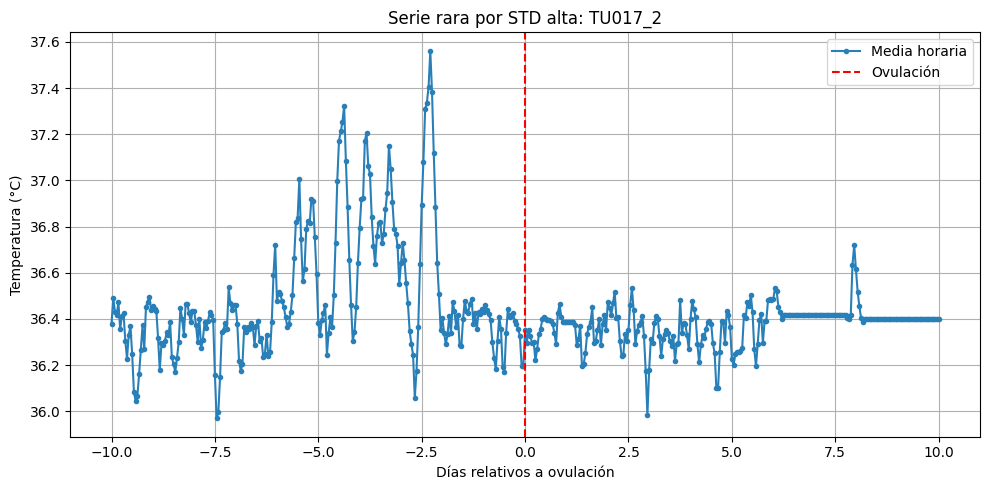

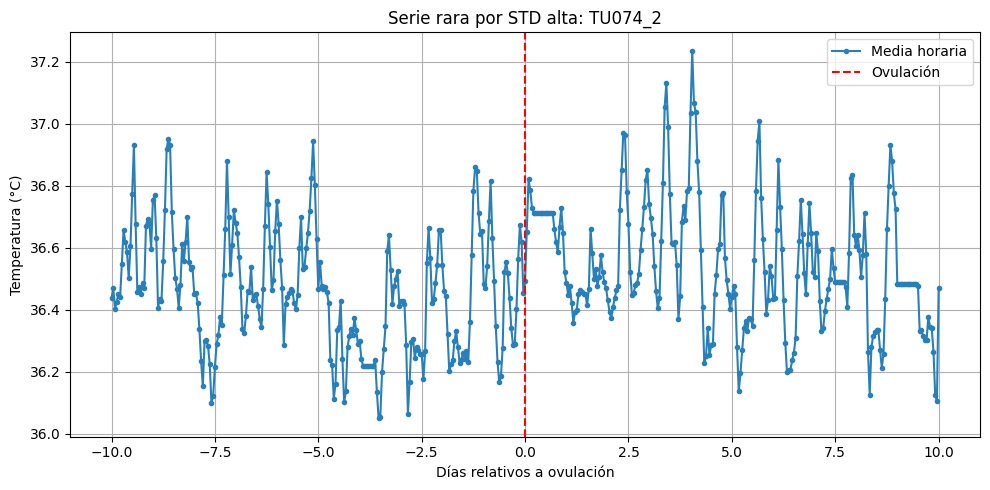

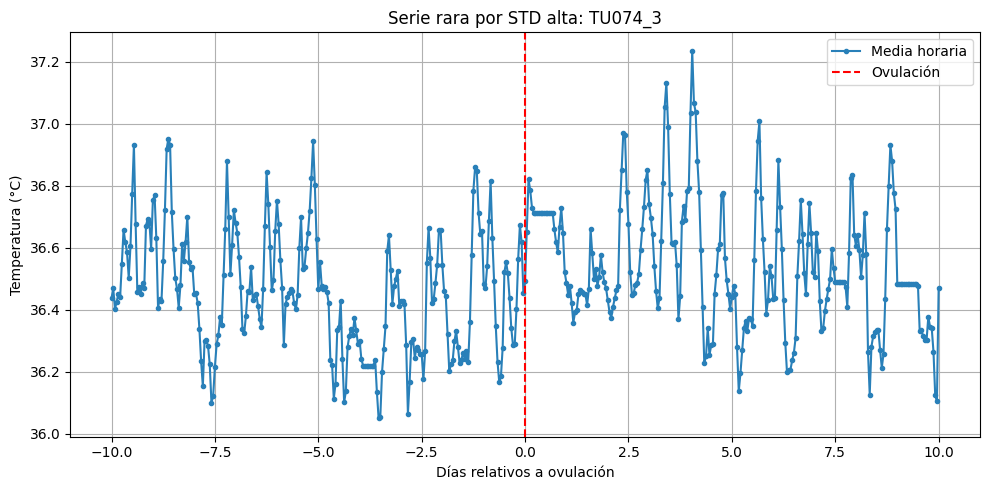

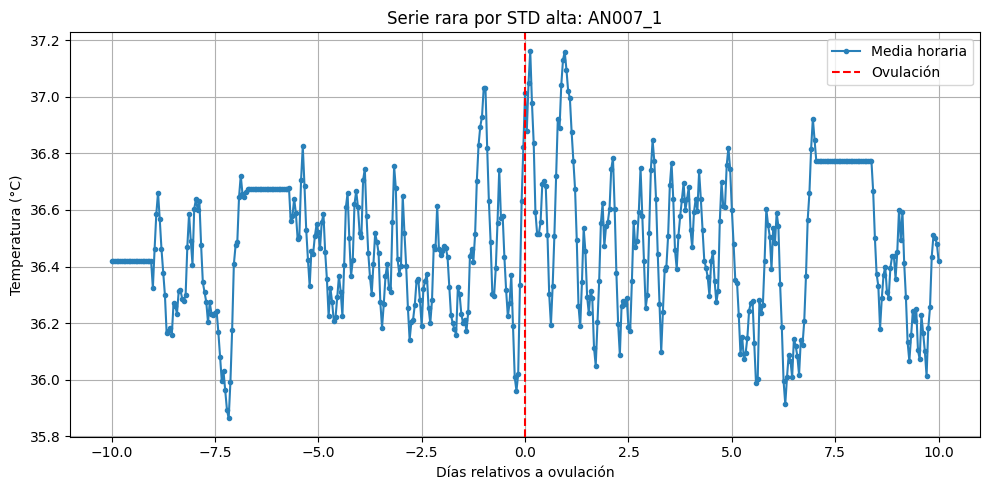

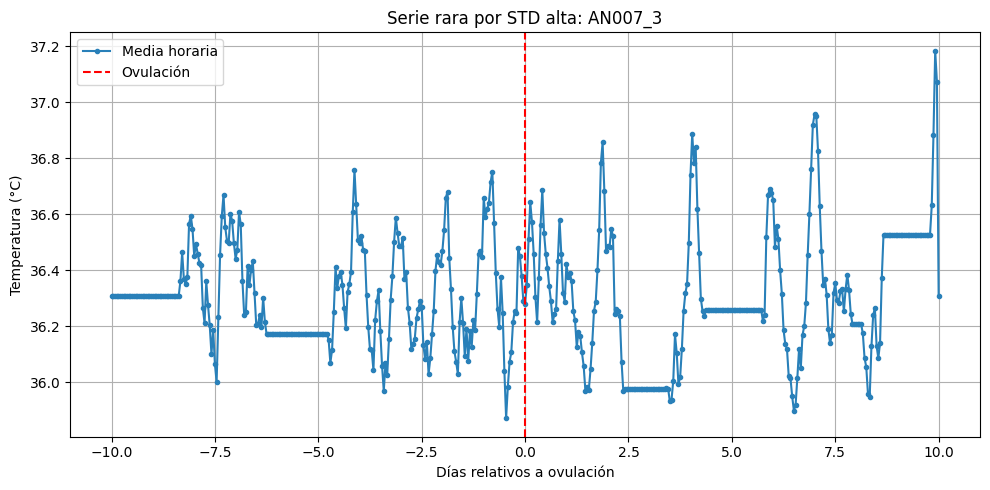

In [84]:
for key in series_raras_std:
    df = muestras_ovul_horas[key]["serie"].copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)

    plt.figure(figsize=(10, 5))
    plt.plot(df["dias_rel"], df["result"], marker=".", color="#2980B9", label="Media horaria")
    plt.axvline(0, color="red", linestyle="--", linewidth=1.5, label="Ovulación")

    plt.title(f"Serie rara por STD alta: {key}")
    plt.xlabel("Días relativos a ovulación")
    plt.ylabel("Temperatura (°C)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Series alineadas con medias de 36.5ºC

In [85]:
muestras_ovul_horas_norm1 = {}

for id, datos in muestras_ovul_horas.items():
    df = datos["serie"].copy()
    mean = df["result"].mean()
    df["result"] = df["result"] - mean + 36.5
    muestras_ovul_horas_norm1[id] = {"serie": df, "ovul" : datos["ovul"]}

In [86]:
todas_series_norm1 = []

for datos in muestras_ovul_horas_norm1.values():
    df = datos["serie"]
    todas_series_norm1.append(df[["resultTimestamp", "result"]])

df_shift = pd.concat(todas_series_norm1)
resumen_norm1 = df_shift.groupby("resultTimestamp").agg(["mean", "std"]).reset_index()
resumen_norm1.columns = ["resultTimestamp", "mean", "std"]

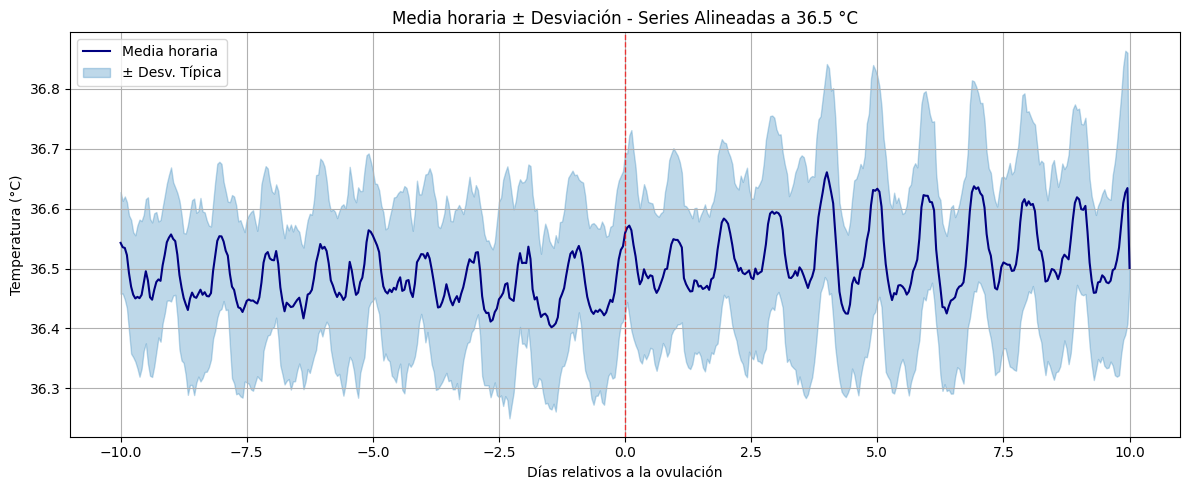

In [87]:
# Gráfico
x_norm1 = (resumen_norm1["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)

plt.figure(figsize=(12, 5))
plt.plot(x_norm1, resumen_norm1["mean"], label="Media horaria", color="navy")
plt.fill_between(
    x_norm1,
    resumen_norm1["mean"] - resumen_norm1["std"],
    resumen_norm1["mean"] + resumen_norm1["std"],
    color="#2980B9", alpha=0.3, label="± Desv. Típica"
)
plt.axvline(x=0, color="red", linestyle="--", linewidth=1, alpha=0.7)
plt.title("Media horaria ± Desviación - Series Alineadas a 36.5 °C")
plt.xlabel("Días relativos a la ovulación")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

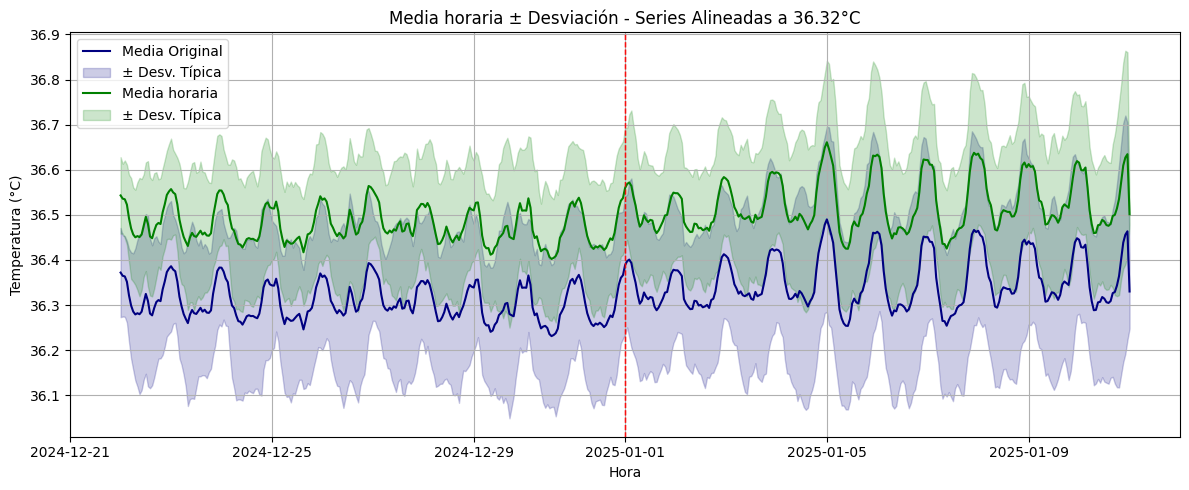

In [88]:
# Gráfico
plt.figure(figsize=(12, 5))
plt.plot(resumen_orig["resultTimestamp"], resumen_orig["mean"], label="Media Original", color="navy")
plt.fill_between(
    resumen_orig["resultTimestamp"],
    resumen_orig["mean"] - resumen_orig["std"],
    resumen_orig["mean"] + resumen_orig["std"],
    color="navy", alpha=0.2, label="± Desv. Típica"
)
plt.axvline(x=fecha_ref, color="red", linestyle="--", linewidth=1, alpha=0.7)
plt.title("Media ± Desviación Típica (Datos Originales)")
plt.xlabel("Hora")
plt.ylabel("Valor original")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.plot(resumen_norm1["resultTimestamp"], resumen_norm1["mean"], label="Media horaria", color="green")
plt.fill_between(
    resumen_norm1["resultTimestamp"],
    resumen_norm1["mean"] - resumen_norm1["std"],
    resumen_norm1["mean"] + resumen_norm1["std"],
    color="green", alpha=0.2, label="± Desv. Típica"
)
plt.axvline(x=fecha_ref, color="red", linestyle="--", linewidth=1, alpha=0.7)
plt.title("Media horaria ± Desviación - Series Alineadas a 36.32°C")
plt.xlabel("Hora")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Normalizar

In [89]:
muestras_ovul_horas_norm2 = {}

for id, datos in muestras_ovul_horas.items():
    df = datos["serie"].copy()
    mean = df["result"].mean()
    std = df["result"].std()
    df["result"] = (df["result"] - mean) / std
    muestras_ovul_horas_norm2[id] = {"serie": df, "ovul" : datos["ovul"]}

In [90]:
todas_series_norm2 = []

for datos in muestras_ovul_horas_norm2.values():
    df = datos["serie"]
    todas_series_norm2.append(df[["resultTimestamp", "result"]])

df_shift = pd.concat(todas_series_norm2)
resumen_norm2 = df_shift.groupby("resultTimestamp").agg(["mean", "std"]).reset_index()
resumen_norm2.columns = ["resultTimestamp", "mean", "std"]

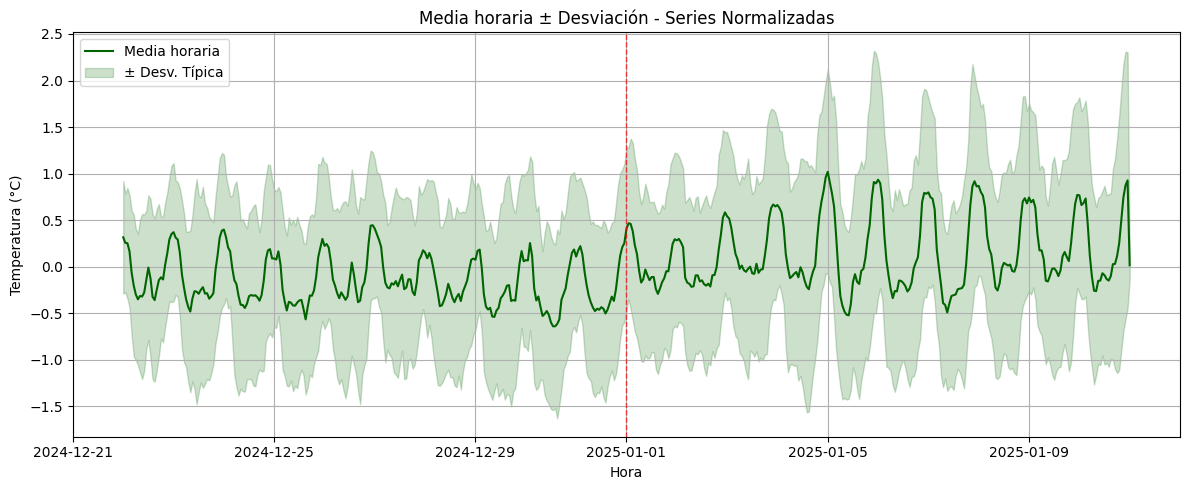

In [91]:
# Gráfico
plt.figure(figsize=(12, 5))
plt.plot(resumen_norm2["resultTimestamp"], resumen_norm2["mean"], label="Media horaria", color="darkgreen")
plt.fill_between(
    resumen_norm2["resultTimestamp"],
    resumen_norm2["mean"] - resumen_norm2["std"],
    resumen_norm2["mean"] + resumen_norm2["std"],
    color="darkgreen", alpha=0.2, label="± Desv. Típica"
)
plt.axvline(x=fecha_ref, color="red", linestyle="--", linewidth=1, alpha=0.7)
plt.title("Media horaria ± Desviación - Series Normalizadas")
plt.xlabel("Hora")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Guardar series normalizadas

In [92]:
with open("../procData/muestras_ovul_horas_norm1.pkl", "wb") as f:
    pickle.dump(muestras_ovul_horas_norm1, f)

In [93]:
with open("../procData/muestras_ovul_horas_norm2.pkl", "wb") as f:
    pickle.dump(muestras_ovul_horas_norm2, f)